In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import os
import struct
import numpy as np




In [3]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

In [4]:

def load_mnist(path, kind='train'):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte'
                               % kind)
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II',
                                 lbpath.read(8))
        labels = np.fromfile(lbpath,
                             dtype=np.uint8)

    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack('>IIII',
                                               imgpath.read(16))
        images = np.fromfile(imgpath,
                             dtype=np.uint8).reshape((len(labels),28,28))

    return images, labels

In [5]:
X_train, y_train = load_mnist('./data')
                              
X_test, y_test = load_mnist('./data',kind='t10k')
print(X_test.shape,y_test.shape)

(10000, 28, 28) (10000,)


In [6]:
def img_show(img):
    plt.figure(figsize=(1,1))
    plt.imshow(img,cmap='Greys',interpolation='nearest')
    

In [7]:
def imgs_show(imgs,row,col):
    fig,ax = plt.subplots(nrows=row,ncols=col,sharex=True,sharey=True)
    ax = ax.flatten()
    for i in range(row*col):
        img = imgs[i]
        ax[i].imshow(img,cmap='Greys', interpolation='nearest')
    
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    plt.tight_layout()
    plt.show()
    
    

In [8]:
def normal_minist(img):
    return (img / 255) -0.5

In [9]:
def expend_HWC(img):
    return np.expand_dims(img,axis=3)


In [10]:
def to_CHW(img):
    return np.transpose(img,(0,3,1,2))
def to_HWC(img):
    return np.transpose(img,(0,2,3,1))

In [11]:
#只能运行一次
X_train_nor = expend_HWC(X_train)
X_train_nor = normal_minist(X_train_nor)
X_train_nor = to_CHW(X_train_nor)
print(X_train_nor.shape)

X_test_nor = expend_HWC(X_test)
X_test_nor = normal_minist(X_test_nor)
X_test_nor = to_CHW(X_test_nor)
print(X_test_nor.shape)




(60000, 1, 28, 28)
(10000, 1, 28, 28)


In [12]:
eval_index = 0


In [13]:

test_postitive = X_test_nor[y_test == eval_index]
test_nagivate = X_test_nor[y_test != eval_index]
print(test_postitive.shape)
print(test_nagivate.shape)


train_positive = X_train_nor[y_train == eval_index][[0,55,1111,1009,327,128,5000,469,2000,3001]]
# imgs_show(train_positive,2,5)
# train_nagivate = np.concatenate((train_1 , train_2 ,train_3 , train_4 ,train_5 ,
#                                  train_6 , train_7 ,train_8 ,train_9)) 
train_nagivate = X_train_nor[y_train != eval_index]

print(train_nagivate.shape)
print(train_positive.shape)

# imgs_show(train_nagivate[:25],5,5)



(980, 1, 28, 28)
(9020, 1, 28, 28)
(54077, 1, 28, 28)
(10, 1, 28, 28)


In [14]:
shuf_index = np.random.permutation(len(train_nagivate))

[[-0.5        -0.5        -0.5        -0.5        -0.5        -0.5
  -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
  -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
  -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
  -0.5        -0.5        -0.5        -0.5       ]
 [-0.5        -0.5        -0.5        -0.5        -0.5        -0.5
  -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
  -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
  -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
  -0.5        -0.5        -0.5        -0.5       ]
 [-0.5        -0.5        -0.5        -0.5        -0.5        -0.5
  -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
  -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
  -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
  -0.5        -0.5        -0.5        -0.5       ]
 [-0.5        -0.5        -0.5        -0.5 

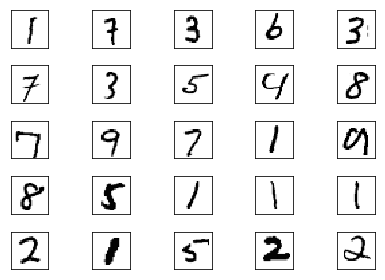

In [15]:
print(train_positive[0][0])
imgs_show(np.squeeze (train_nagivate[50000:50025]),5,5)


In [16]:
def num_flat_features(x):
    size = x.size()[1:]
    num_features =1
        
    for s in size:
        num_features *= s
    return num_features
        

In [17]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5,stride=2)
        self.bn_conv1 = nn.BatchNorm2d(10)
#         self.conv2 = nn.Conv2d(10, 10, kernel_size=3,stride=2)
        self.conv3 = nn.Conv2d(10,20,kernel_size=5,stride=2)
        self.bn_conv3 = nn.BatchNorm2d(20)
#         self.conv4 = nn.Conv2d(20,20,kernel_size=3,stride=2)
        
        self.conv3_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.bn_fc1 = nn.BatchNorm1d(50)
        self.fc2 = nn.Linear(50, 10)
        self.features={}


    def forward(self, x):
        
        x = self.conv1(x)
        self.features['conv1'] = x
        x = self.bn_conv1(x)
        self.features['bn_conv1'] = x
        x = F.relu(x)
        self.features['relu1'] = x
        
        x = self.conv3(x)
        self.features['conv3'] = x
        x = self.bn_conv3(x)
        self.features['bn_conv3'] = x
        x = F.relu( x)
        self.features['relu3'] = x
        
        x = x.view(-1, num_flat_features(x))
        self.features['flat'] = x
        
        x = self.fc1(x)
        self.features['fc1'] = x
        x = self.bn_fc1(x)
        self.features['bn_fc1'] = x
        x = F.relu(x)
        self.features['relu_fc1'] = x
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        self.features['fc2'] = x
        return F.log_softmax(x, dim=1)
    


In [26]:
print(net)
print(net.conv1.weight.size())

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(2, 2))
  (bn_conv1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(10, 20, kernel_size=(5, 5), stride=(2, 2))
  (bn_conv3): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3_drop): Dropout2d(p=0.5)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (bn_fc1): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)
torch.Size([10, 1, 5, 5])


In [47]:
class MyNet(nn.Module):
    def __init__(self,net):
        super(MyNet,self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5,stride=2)
        self.conv2 = nn.Conv2d(10,20,kernel_size=5,stride=2)
        
        self.conv1.weight.data.copy_(net.conv1.weight.data)
        self.conv1.bias.data.copy_(net.conv1.bias.data)
        self.conv2.weight.data.copy_(net.conv3.weight.data)
        self.conv2.bias.data.copy_(net.conv3.bias.data)
        
        self.deconv2 = nn.
        
        
 

        
        

In [49]:
mynet2 = MyNet(net)
print(mynet2.conv1.weight.data[0][0])

tensor([[-0.0472, -0.0553, -0.0944, -0.0971, -0.0782],
        [-0.1185, -0.0392, -0.1008,  0.0189, -0.1222],
        [-0.0591,  0.0144,  0.0932,  0.0062, -0.0043],
        [ 0.1198,  0.0193, -0.0030, -0.1095,  0.0583],
        [-0.0587, -0.0325,  0.0001,  0.1000, -0.0287]])


In [43]:
print(net.conv1.weight.data[0][0])

tensor([[-0.0472, -0.0553, -0.0944, -0.0971, -0.0782],
        [-0.1185, -0.0392, -0.1008,  0.0189, -0.1222],
        [-0.0591,  0.0144,  0.0932,  0.0062, -0.0043],
        [ 0.1198,  0.0193, -0.0030, -0.1095,  0.0583],
        [-0.0587, -0.0325,  0.0001,  0.1000, -0.0287]], dtype=torch.float64)


In [46]:
mynet = MyNet()
print(mynet.conv1.weight.data[0][0])
print(mynet.conv1.bias.data)
mynet.conv1.weight.data.copy_(net.conv1.weight.data)
mynet.conv1.bias.data

print(mynet.conv1.weight.data[0][0])
print(mynet.conv1.bias.data)

tensor([[ 0.1095,  0.1298, -0.1907, -0.0047, -0.1284],
        [ 0.1837, -0.0136,  0.0590, -0.1852, -0.0564],
        [-0.1527,  0.0479,  0.1718, -0.1901, -0.0928],
        [-0.1948, -0.1328, -0.0734,  0.0805, -0.1447],
        [-0.1795,  0.1884, -0.0198, -0.0536,  0.1589]])
tensor([-0.0539, -0.1334,  0.0089,  0.1304, -0.1967, -0.1776, -0.0055,
         0.0042, -0.0678, -0.1817])
tensor([[-0.0472, -0.0553, -0.0944, -0.0971, -0.0782],
        [-0.1185, -0.0392, -0.1008,  0.0189, -0.1222],
        [-0.0591,  0.0144,  0.0932,  0.0062, -0.0043],
        [ 0.1198,  0.0193, -0.0030, -0.1095,  0.0583],
        [-0.0587, -0.0325,  0.0001,  0.1000, -0.0287]])
tensor([-0.0539, -0.1334,  0.0089,  0.1304, -0.1967, -0.1776, -0.0055,
         0.0042, -0.0678, -0.1817])


In [18]:
def getnext(train_x,train_y,batch_size):
    batchs = len(train_y) // batch_size
    print(len(train_y),batchs)

    for i in range(batchs):
        x = train_x[batch_size * i : batch_size * (i+1)]
        y = train_y[batch_size * i : batch_size * (i+1)]
        yield x,y
        

In [19]:
def get_nagivate_next(train_positive,train_nagivate):
    batch_size = len(train_positive)
    batchs = len(train_nagivate) // batch_size
    print(len(train_nagivate),batchs)
    
    for i in range(batchs):
        x = np.concatenate((train_positive,train_nagivate[batch_size * i : batch_size * (i+1)]))
        y = np.concatenate((np.zeros(batch_size),np.ones(batch_size)))
        shuf_index = np.random.permutation(len(y))
        x = x[shuf_index]
        y = y[shuf_index]
        
        
        yield x ,y 
        

10 1
(20, 1, 28, 28)
[1. 0. 0. 1. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0.]


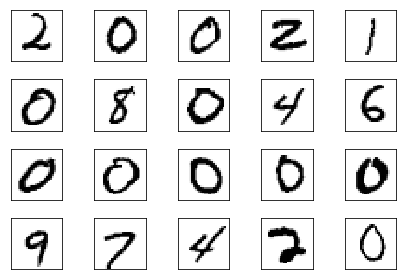

In [20]:
datas = get_nagivate_next(train_positive,train_nagivate[100:110])
for x,y in datas:
    print(x.shape)
    
    print(y)
    imgs_show(np.squeeze( x),4,5)


In [21]:
use_cuda = torch.cuda.is_available()
torch.manual_seed(666)
device = torch.device("cuda" if use_cuda else "cpu")
net = Net().to(device)
net.double()

optimizer = optim.SGD(net.parameters(),lr=0.003,momentum=0.9,weight_decay=3e-4)


In [22]:
net.train()
for epoch in range(10):
    datas = get_nagivate_next(train_positive,train_nagivate)
    trainloss = 0
    
    for x,y in datas:
        inputs, labels = Variable(torch.from_numpy(x)).to(device), Variable(torch.from_numpy(y).long()).to(device)
#         print(labels)
        optimizer.zero_grad()
        output = net(inputs)
#         print(output.size())
        loss = F.nll_loss(output,labels)
        trainloss += loss.item()
        loss.backward()
        optimizer.step()
        
    print('%d  loss: %.3f' % (epoch ,  trainloss))
torch.save(net,'model_nagivate.pkl')

54077 5407


KeyboardInterrupt: 

In [23]:
net = torch.load('model_nagivate.pkl')
net.to(device)
net.eval()
test_loss = 0
correct = 0
correct = 0
test_loss = 0

with torch.no_grad():
    test_datas = getnext(test_postitive,np.zeros(len(test_postitive)),4)
    for x ,y in test_datas:
        inputs, labels = Variable(torch.from_numpy(x)).to(device), Variable(torch.from_numpy(y).long()).to(device)
        output = net(inputs)
        test_loss += F.nll_loss(output, labels, size_average=False).item() # sum up batch loss
        pred = output.max(1,keepdim=True)[1]
#         print(pred)
        correct += pred.eq(labels.view_as(pred)).sum().item()
#         print(correct)

print('\nTest set: Average loss: {:.4f}, Accuracy: {} ({:.4f}%)\n'.format(
        test_loss, correct,100. * correct / len(test_postitive)))


correct = 0
test_loss = 0
with torch.no_grad():
    test_datas = getnext(test_nagivate,np.ones(len(test_nagivate)),4)
    for x ,y in test_datas:
        inputs, labels = Variable(torch.from_numpy(x)).to(device), Variable(torch.from_numpy(y).long()).to(device)
        output = net(inputs)
        test_loss += F.nll_loss(output, labels, size_average=False).item() # sum up batch loss
        pred = output.max(1,keepdim=True)[1]
#         print(pred)
        correct += pred.eq(labels.view_as(pred)).sum().item()
#         print(correct)

print('\nTest set: Average loss: {:.4f}, Accuracy: {} ({:.4f}%)\n'.format(
        test_loss, correct,100. * correct / len(test_nagivate)))
        
        
        

980 245

Test set: Average loss: 3968.2369, Accuracy: 390 (39.7959%)

9020 2255

Test set: Average loss: 0.5253, Accuracy: 9020 (100.0000%)



(1, 1, 28, 28)
tensor([[ 1]])
(20, 4, 4)
torch.Size([10, 1, 5, 5])


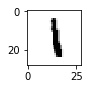

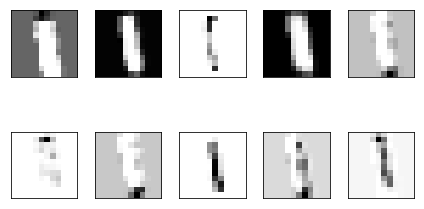

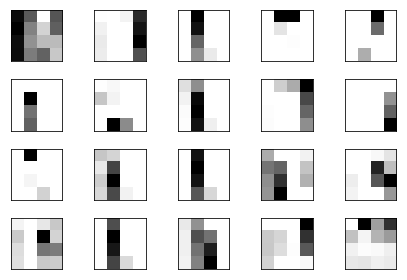

[[1.18697507 0.88669411 0.         0.90950004]
 [1.23281832 0.70167435 0.3382119  0.86026838]
 [1.17285807 0.63917822 0.46829796 0.46949561]
 [1.17875117 0.72980026 0.84525493 0.39997723]]


In [34]:
net.eval()
with torch.no_grad():
    x = train_nagivate[5:6]
    print(x.shape)
    inputs = Variable(torch.from_numpy(x)).to(device)
    output = net(inputs)
    pred = output.max(1,keepdim=True)[1]
    print(pred)
    imgs_relu1 = np.squeeze(net.features['relu1'].cpu().numpy())
    imgs_relu3 = np.squeeze(net.features['relu3'].cpu().numpy())
#     print(x.shape)
    
    print(imgs_relu3.shape)
#     print(net.features['relu2'].size())
#     print(net.features['relu3'].size())
#     print(net.features['relu4'].size())
#     print(net.features['flat'].size())
#     print(imgs_relu1[9])
    print(net.conv1.weight.size())
    img_show(np.squeeze(x))
    imgs_show( imgs_relu1,2,5)
    imgs_show( imgs_relu3,4,5)

#     imgs_show(np.squeeze(net.conv1.weight),2,5)
#     imgs_show(np.squeeze(net.conv2.weight),2,5)
    

In [36]:
print(imgs_relu1[1])

[[2.68781281 2.68781281 2.68781281 2.68781281 2.66856792 2.44235809
  2.19630995 2.57729757 2.68781281 2.68781281 2.68781281 2.68781281]
 [2.68781281 2.68781281 2.68781281 2.68781281 1.9679733  0.
  0.51175563 2.35089814 2.68781281 2.68781281 2.68781281 2.68781281]
 [2.68781281 2.68781281 2.68781281 2.68781281 1.95569453 0.
  0.         2.31131008 2.68781281 2.68781281 2.68781281 2.68781281]
 [2.68781281 2.68781281 2.68781281 2.68781281 1.86884248 0.
  0.         1.96122135 2.65026442 2.68781281 2.68781281 2.68781281]
 [2.68781281 2.68781281 2.68781281 2.68781281 2.34460371 0.
  0.         1.19872412 2.61057455 2.68781281 2.68781281 2.68781281]
 [2.68781281 2.68781281 2.68781281 2.68781281 2.73040526 0.23104702
  0.         1.02731236 2.66561465 2.68781281 2.68781281 2.68781281]
 [2.68781281 2.68781281 2.68781281 2.68781281 2.68781281 0.26350251
  0.         0.97099672 2.6413123  2.68781281 2.68781281 2.68781281]
 [2.68781281 2.68781281 2.68781281 2.68781281 2.68781281 0.29323539
  0. 

(1, 1, 28, 28)
tensor([[ 1]])
(20, 4, 4)
torch.Size([10, 1, 5, 5])


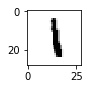

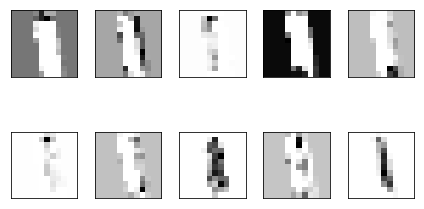

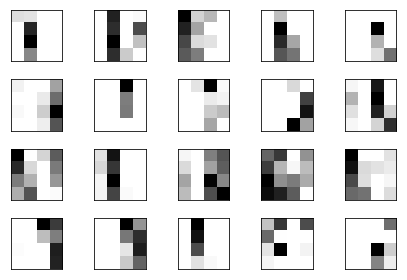

In [24]:
net.eval()
with torch.no_grad():
    x = train_nagivate[5:6]
    print(x.shape)
    inputs = Variable(torch.from_numpy(x)).to(device)
    output = net(inputs)
    pred = output.max(1,keepdim=True)[1]
    print(pred)
    imgs_relu1 = np.squeeze(net.features['relu1'].cpu().numpy())
    imgs_relu3 = np.squeeze(net.features['relu3'].cpu().numpy())
#     print(x.shape)
    
    print(imgs_relu3.shape)
#     print(net.features['relu2'].size())
#     print(net.features['relu3'].size())
#     print(net.features['relu4'].size())
#     print(net.features['flat'].size())
#     print(imgs_relu1[9])
    print(net.conv1.weight.size())
    img_show(np.squeeze(x))
    imgs_show( imgs_relu1,2,5)
    imgs_show( imgs_relu3,4,5)

In [29]:
print(imgs_relu3[3])

[[-0.68485275 -0.50999981 -0.43465212 -0.45784687]
 [-0.73661396 -0.43044509 -0.37152805 -0.3443784 ]
 [-0.72282045 -0.50983617 -0.33612174 -0.35435209]
 [-0.714755   -0.50599442 -0.32503906 -0.40327045]]
